# ICS5110 Assignment

## Imports

In [1]:
%pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc, classification_report, confusion_matrix

## Fetching Dataset

In [2]:
dataset = fetch_ucirepo(id=2)

print(dataset.variables) # variable information

# Converting Dataset to Pandas DF
X = dataset.data.features
y = dataset.data.targets

dataset = pd.concat([X, y], axis=1)

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

In [3]:
dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


## Data Cleaning & Preperation

In [4]:
# Removing fnlwgt as we think it is not relevant for predictions and education as is represented numerically by column 'education-num'
dataset = dataset.drop(['fnlwgt', 'education'], axis=1)

### Removing Rows of data which contain any N/A values

In [5]:
print(dataset.shape[0])

dataset = dataset.replace('?', np.nan)
dataset = dataset.dropna()

print(dataset.shape[0])

48842
45222


### Performing Label Encoding

#### One-Hot Encoding (On Nominal Variables)

In [6]:
dataset = pd.get_dummies(dataset, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], drop_first=False)

#### Label Encoding the Target Variable

In [7]:
print(dataset['income'].unique())

# Removing the trailing period from target values

dataset.loc[:, 'income'] = dataset['income'].str.replace('.', '', regex=False)
print(dataset['income'].unique())

['<=50K' '>50K' '<=50K.' '>50K.']
['<=50K' '>50K']


In [8]:
label_encoder = LabelEncoder()

print("Original Data:", dataset['income'])
dataset['income'] = label_encoder.fit_transform(dataset['income'])
print("Encoded Data:", dataset['income'])

Original Data: 0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
48836    <=50K
48837    <=50K
48839    <=50K
48840    <=50K
48841     >50K
Name: income, Length: 45222, dtype: object
Encoded Data: 0        0
1        0
2        0
3        0
4        0
        ..
48836    0
48837    0
48839    0
48840    0
48841    1
Name: income, Length: 45222, dtype: int64


In [9]:
dataset

,age,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,13,2174,0,40,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,13,0,0,13,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,9,0,0,40,0,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,53,7,0,0,40,0,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,28,13,0,0,40,0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,13,0,0,40,0,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
48837,39,13,0,0,36,0,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
48839,38,13,0,0,50,0,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
48840,44,13,5455,0,40,0,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


### Normalising Numerical Data

In [10]:
scaler = MinMaxScaler()
dataset[['age', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(dataset[['age', 'capital-gain', 'capital-loss', 'hours-per-week']])

### Splitting Dataset into Training and Target Variables

In [11]:
X = dataset.drop('income', axis=1) # training variables
y = dataset['income'] # target variable

### Handling Class Imbalance

In [12]:
smote = SMOTE(random_state=1)
X, y = smote.fit_resample(X, y) # SMOTE is used to oversample the minority class

### Splitting Dataset into Train (80%) and Test (20%)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Model Implementations

### K-Nearest Neighbours

In [ ]:
# Define a range of k values to test
param_grid = {'n_neighbors': range(1, 21)}

# Perform grid search with cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best k:", grid_search.best_params_['n_neighbors'])

In [ ]:
k = grid_search.best_params_['n_neighbors']
knn = KNeighborsClassifier(n_neighbors=k)

knn.fit(X_train, y_train)

In [ ]:
with open('k-nn_model.pkl', 'wb') as file:
  pickle.dump(knn, file)

### Random Forest

In [ ]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=20, cv=3, random_state=42, n_jobs=-1, error_score='raise')

rf.fit(X_train, y_train)

In [ ]:
with open('rf_model.pkl', 'wb') as file:
  pickle.dump(rf, file)

### Decision Trees

In [ ]:
dt = DecisionTreeClassifier(random_state=1)

dt.fit(X_train, y_train)

In [ ]:
with open('dt_model.pkl', 'wb') as file:
  pickle.dump(dt, file)

### Logistical Regression

In [14]:
# Define a Sigmoid function, input Z, return y
def sigmoid(z):
    y_hat = 1 / (1 + np.exp((-z).flatten().tolist()))
    return y_hat

In [15]:
# Define Loss function
def loss_function(X, y, w, b):
    y_hat = sigmoid(np.dot(X, w) + b)
    loss = -((y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))
    cost = np.sum(loss) / X.shape[0]
    return cost

In [16]:
# Define gradient descent function
def gradient_descent(X, y, w, b, alpha, iterations):
    l_history = np.zeros(iterations)
    w_history = np.zeros((iterations, w.shape[0]))
    b_history = np.zeros(iterations)

    for i in range(iterations):
        y_hat = sigmoid(np.dot(X, w) + b)
        loss = -((y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))
        derivative_w = np.dot(X.T, (y_hat - y)) / X.shape[0]
        derivative_b = np.sum(y_hat - y) / X.shape[0]
        w = w - alpha * derivative_w
        b = b - alpha * derivative_b
        l_history[i] = loss_function(X, y, w, b)

        # Print current loss
        print("Iteration", i + 1, "Current Loss:", l_history[i])

        w_history[i] = w
        b_history[i] = b

    return l_history, w_history, b_history

In [17]:
def predict_proba_lr(X, w, b):
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    return y_hat

In [18]:
# Define prediction function
def predict_lr(X, w, b):
    y_hat = predict_proba_lr(X, w, b)
    y_pred = np.zeros_like(y_hat)

    for i in range(y_hat.shape[0]):
        if y_hat[i] < 0.5:
            y_pred[i] = 0
        else:
            y_pred[i] = 1
    return y_pred

In [19]:
# Define logistic regression model
def logistic_regression(X, y, w, b, lr, iter):
    l_history, w_history, b_history = gradient_descent(X, y, w, b, lr, iter)
    print("Training Final Loss:", l_history[-1])

    y_pred_train = predict_lr(X, w_history[-1], b_history[-1])
    train_acc = 100 - np.mean(np.abs(y_pred_train - y)) * 100
    print("Logistic Regression Train Accuracy: {:.2f}%".format(train_acc))

    return l_history, w_history, b_history

In [ ]:
# Model initialization
dimension = X.shape[1]
weight = 0.1 * np.ones((dimension, 1)).flatten()
bias = 0
alpha = 0.1  # Learning rate
iterations = 100  # Number of iterations

# Run logistic regression
loss_history, weight_history, bias_history = logistic_regression(X_train, y_train, weight, bias, alpha, iterations)

In [ ]:
# Save weights and bias
lr = {
    "weights": weight_history[-1],
    "bias": bias_history[-1]
}

with open('lr_model.pkl', 'wb') as file:
    pickle.dump(lr, file)

## Evaluation

### K-Nearest Neighbours

In [20]:
with open('k-nn_model.pkl', 'rb') as file:
    knn = pickle.load(file)

#### Classification Report

In [21]:
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

precision_curve_knn, recall_curve_knn, thresholds_knn = precision_recall_curve(y_test, y_prob_knn)

# Calculate the AUC for the PR curve
pr_auc_knn = auc(recall_curve_knn, precision_curve_knn)

print(f'Accuracy: {accuracy_knn:.2f}')
print(f'Precision: {precision_knn:.2f}')
print(f'Recall: {recall_knn:.2f}')
print(f'F1 Score: {f1_knn:.2f}')
print(f"AUC-PR Score: {pr_auc_knn:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.85
Precision: 0.82
Recall: 0.88
F1 Score: 0.85
AUC-PR Score: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      6849
           1       0.82      0.88      0.85      6757

    accuracy                           0.85     13606
   macro avg       0.85      0.85      0.85     13606
weighted avg       0.85      0.85      0.85     13606



#### Confusion Matrix

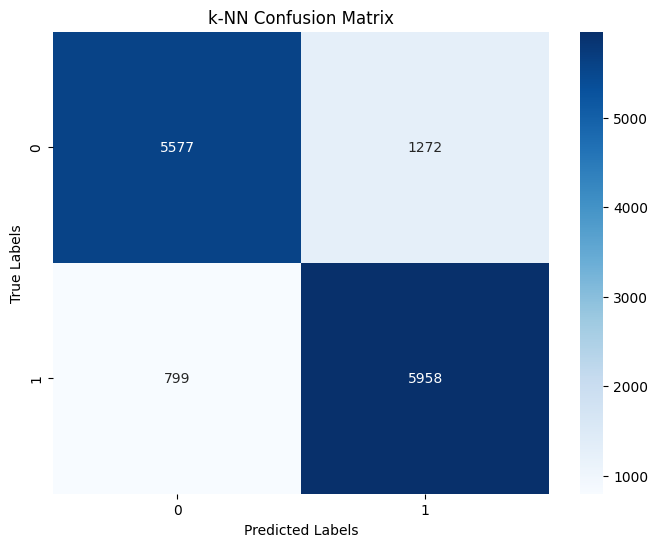

In [22]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('k-NN Confusion Matrix')
plt.show()

#### PR Curve

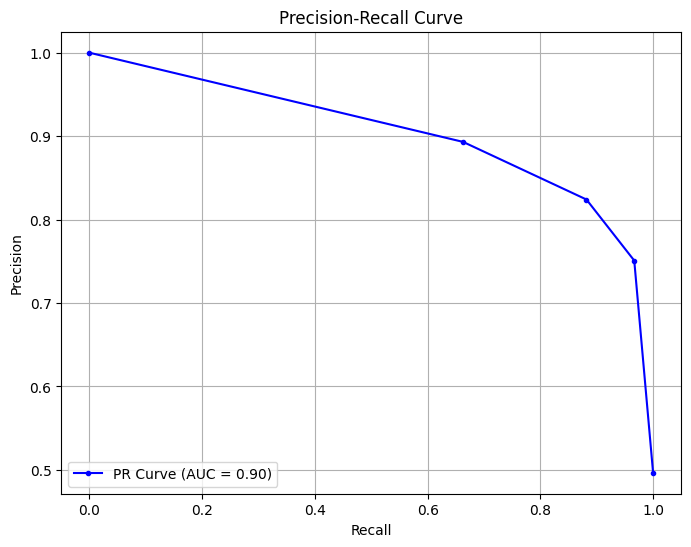

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_knn, precision_curve_knn, marker='.', color='b', label=f'PR Curve (AUC = {pr_auc_knn:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Random Forests

In [24]:
with open('rf_model.pkl', 'rb') as file:
    rf = pickle.load(file)

#### Classification Report

In [25]:
y_pred_rf= rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

precision_curve_rf, recall_curve_rf, thresholds_rf = precision_recall_curve(y_test, y_prob_rf)

# Calculate the AUC for the PR curve
pr_auc_rf = auc(recall_curve_rf, precision_curve_rf)

print(f'Accuracy: {accuracy_rf:.2f}')
print(f'Precision: {precision_rf:.2f}')
print(f'Recall: {recall_rf:.2f}')
print(f'F1 Score: {f1_rf:.2f}')
print(f"AUC-PR Score: {pr_auc_rf:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.88
Precision: 0.87
Recall: 0.89
F1 Score: 0.88
AUC-PR Score: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6849
           1       0.87      0.89      0.88      6757

    accuracy                           0.88     13606
   macro avg       0.88      0.88      0.88     13606
weighted avg       0.88      0.88      0.88     13606



#### Confusion Matrix

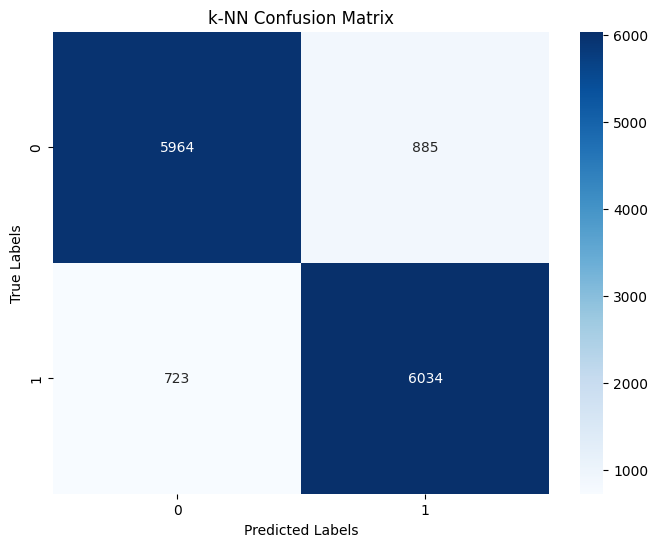

In [26]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('k-NN Confusion Matrix')
plt.show()

#### PR Curve

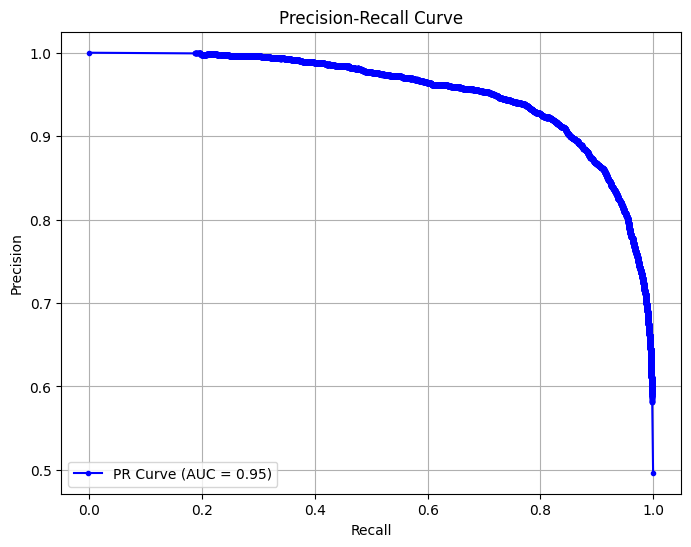

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_rf, precision_curve_rf, marker='.', color='b', label=f'PR Curve (AUC = {pr_auc_rf:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Decision Tree

In [28]:
with open('dt_model.pkl', 'rb') as file:
    dt = pickle.load(file)

#### Classification Report

In [29]:
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

precision_curve_dt, recall_curve_dt, thresholds_dt = precision_recall_curve(y_test, y_prob_dt)

# Calculate the AUC for the PR curve
pr_auc_dt = auc(recall_curve_dt, precision_curve_dt)

print(f'Accuracy: {accuracy_dt:.2f}')
print(f'Precision: {precision_dt:.2f}')
print(f'Recall: {recall_dt:.2f}')
print(f'F1 Score: {f1_dt:.2f}')
print(f"AUC-PR Score: {pr_auc_dt:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

Accuracy: 0.85
Precision: 0.85
Recall: 0.84
F1 Score: 0.85
AUC-PR Score: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6849
           1       0.85      0.84      0.85      6757

    accuracy                           0.85     13606
   macro avg       0.85      0.85      0.85     13606
weighted avg       0.85      0.85      0.85     13606



#### Confusion Matrix

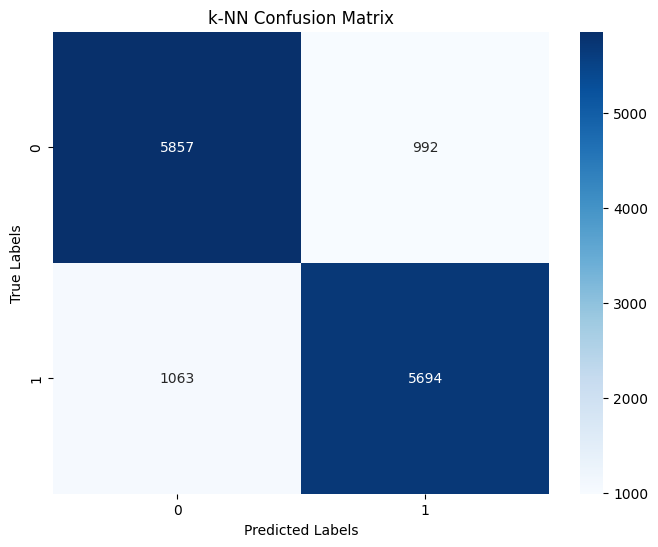

In [30]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('k-NN Confusion Matrix')
plt.show()

#### PR Curve

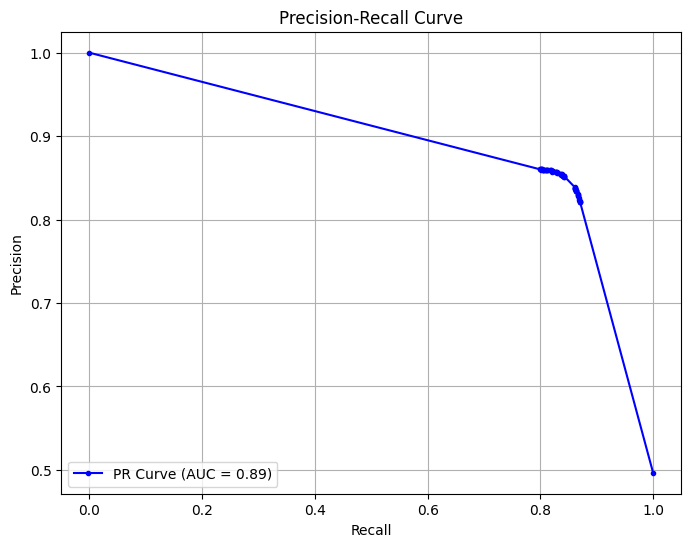

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_dt, precision_curve_dt, marker='.', color='b', label=f'PR Curve (AUC = {pr_auc_dt:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Logistical Regression

In [32]:
with open('lr_model.pkl', 'rb') as file:
    lr = pickle.load(file)

weight_history = lr["weights"]
bias_history = lr["bias"]

#### Classification Report

In [33]:
y_pred_lr = predict_lr(X_test, weight_history, bias_history)
y_prob_lr = predict_proba_lr(X_test, weight_history, bias_history)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

precision_curve_lr, recall_curve_lr, thresholds_lr = precision_recall_curve(y_test, y_prob_lr)

# Calculate the AUC for the PR curve
pr_auc_lr = auc(recall_curve_lr, precision_curve_lr)

print(f'Accuracy: {accuracy_lr:.2f}')
print(f'Precision: {precision_lr:.2f}')
print(f'Recall: {recall_lr:.2f}')
print(f'F1 Score: {f1_lr:.2f}')
print(f"AUC-PR Score: {pr_auc_lr:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.62
Precision: 0.57
Recall: 0.99
F1 Score: 0.72
AUC-PR Score: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.25      0.39      6849
           1       0.57      0.99      0.72      6757

    accuracy                           0.62     13606
   macro avg       0.77      0.62      0.56     13606
weighted avg       0.77      0.62      0.56     13606



#### Confusion Matrix

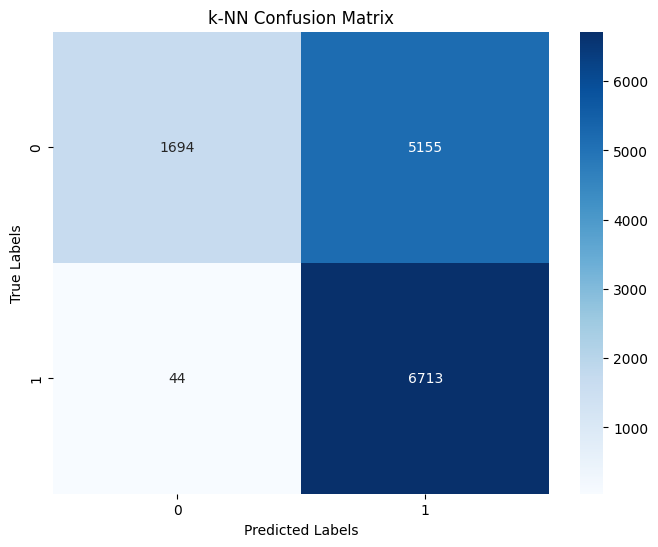

In [34]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('k-NN Confusion Matrix')
plt.show()

#### PR Curve

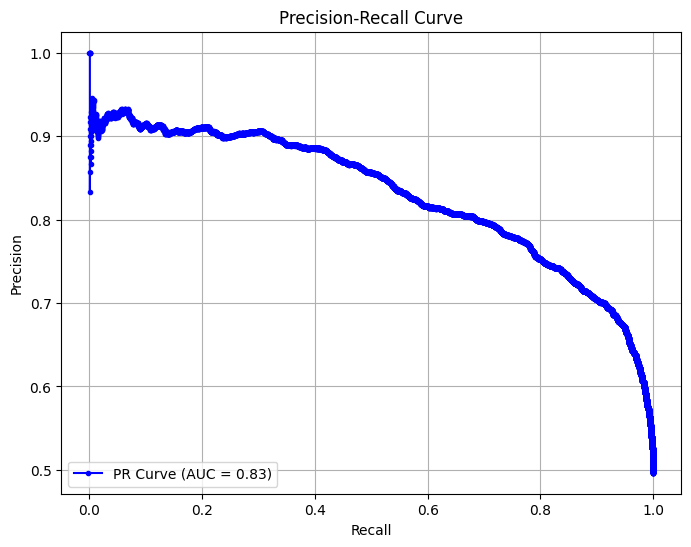

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_lr, precision_curve_lr, marker='.', color='b', label=f'PR Curve (AUC = {pr_auc_lr:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Confusion Matrix for each Model

In [ ]:
y_preds = [y_pred_knn, y_pred_rf, y_pred_lr, y_pred_dt]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

model = ['k-NN', 'Random Forest', 'Logistical Regression', 'Decision Tree']

# Loop through each model's predictions and plot the confusion matrix
for i, y_pred in enumerate(y_preds):
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'],
                yticklabels=['0', '1'], ax=axes[i], cbar=False)

    axes[i].set_title(f'{model[i]} Confusion Matrix')
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()